# Libraries and Setting

In [9]:
#from __future__ import division,print_function
#np.set_printoptions(precision=4, linewidth=100)
#import os, json
#from glob import glob

from os import walk
import itertools
import pandas as pd
import scipy as sp
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
data_path =  '../data1/'

fold_no_list = ['fold1', 'fold2', 'fold3' ,'fold4', 'fold5']
train_type_list = ['train', 'test']
magnif_list = ['40X', '100X', '200X', '400X']
lesion_list = ['benign', 'malignant']

patch_xsize = 350
patch_ysize = 230

base_model = InceptionV3(include_top=False, weights=None, input_shape=(patch_ysize,patch_xsize,3) )

# Functions

In [3]:
def img_norm(img, y=patch_ysize, x=patch_xsize):
    img = sp.misc.imresize(img, (y,x)).astype(np.float)
    img -= np.mean(img, axis=2, keepdims=True)
    img /= (np.std(img, axis=2, keepdims=True) + 1e-7)
    return img

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, '%.2f'%cm[i,j], horizontalalignment='center', color='white' if cm[i,j]>thresh else 'black')
           
    plt.ylabel('Ground Truth')
    plt.xlabel('Predicted Value')
    
def get_no_image(path):
    file_list = []
    for (dirpath, dirnames, filenames) in walk(path):
        file_list.extend(filenames)
    return len(file_list)

def medical_AI(c_fold, c_magnif, df):
    print('current fold: '+c_fold)
    print('current magnification: '+c_magnif)
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    batch_size = 16

    train_datagen = image.ImageDataGenerator(
        preprocessing_function=img_norm,
        horizontal_flip=True,
        vertical_flip = True)

    test_datagen = image.ImageDataGenerator(preprocessing_function=img_norm)

    print('Training Images')
    train_generator = train_datagen.flow_from_directory(
        data_path+c_fold+'/train/'+c_magnif,
        target_size=(patch_ysize, patch_xsize),
        batch_size=batch_size)

    print('Testing Images')
    validation_generator = test_datagen.flow_from_directory(
        data_path+c_fold+'/test/'+c_magnif,
        target_size=(patch_ysize, patch_xsize),
        batch_size=batch_size)
    
    no_train = get_no_image(data_path+c_fold+'/train/'+c_magnif)
    no_test = get_no_image(data_path+c_fold+'/test/'+c_magnif)
    
    class_weight = {}
    for index, lesion in enumerate(lesion_list):
        my_path = data_path+c_fold+'/train/{}/{}'.format(c_magnif, lesion)
        file_list = []
        for (dirpath, dirnames, filenames) in walk(my_path):
            file_list.extend(filenames)
            break 
        class_weight[index] = float(no_train)/ (len(lesion_list)*len(file_list))
    print('class weight:', class_weight)
    
    model.fit_generator(
        train_generator,
        steps_per_epoch = int(float(no_train)/batch_size),
        epochs=20,
        validation_data=validation_generator,
        validation_steps=int(float(no_test)/batch_size),
        verbose=2, class_weight=class_weight)
    
    for lesion in lesion_list:
        my_path = data_path+c_fold+'/test/'+c_magnif+'/{}'.format(lesion)
        file_list = []
        for (dirpath, dirnames, filenames) in walk(my_path):
            file_list.extend(filenames)
            break   
        for file in file_list:
            img = sp.misc.imread(data_path+c_fold+'/test/'+c_magnif+'/{}/{}'.format(lesion, file)) 
            img = img_norm(img)
            img = np.expand_dims(img, axis=0)
            df.loc[df['name']==file, [lesion+'_pred_'+c_fold for lesion in lesion_list]] = model.predict(img, batch_size=1, verbose=0)[0]
    
    return df

# Basic Visualization

In [ ]:
img = sp.misc.imread('../data1/fold1/train/40X/benign/SOB_B_PT-14-22704-40-001.png')

In [ ]:
plt.imshow(img)

# Organise Training Set (do only once)

In [ ]:
fold_no_list = ['fold1', 'fold2', 'fold3' ,'fold4', 'fold5']
train_type_list = ['train', 'test']
magnif_list = ['40X', '100X', '200X', '400X']
lesion_list = ['benign', 'malignant']

for fold_no in fold_no_list:
    for train_type in train_type_list:
        for magnif in magnif_list:           
            for lesion in lesion_list:
                my_path = data_path+'{}/{}/{}/{}'.format(fold_no, train_type, magnif, lesion)

                if not os.path.exists(my_path):
                    os.makedirs(my_path)       
            
            f = []
            my_path2 = data_path+'{}/{}/{}/'.format(fold_no, train_type, magnif)
            for (dirpath, dirnames, filenames) in walk(my_path2):
                f.extend(filenames)
                break    
            for file in f:
                if file[4] == 'M': 
                    os.rename(my_path2+file, my_path2+'malignant/' + file)
                elif file[4] == 'B': 
                    os.rename(my_path2+file, my_path2+'benign/' + file)


# Create patient table

In [4]:
df = pd.DataFrame()
for train_type in train_type_list:
    for magnif in magnif_list:           
        for lesion in lesion_list:
            my_path = data_path+'fold1/{}/{}/{}'.format(train_type, magnif, lesion)
            file_list = []
            for (dirpath, dirnames, filenames) in walk(my_path):
                file_list.extend(filenames)
                break   
            for file in file_list:
                und_pos = [pos for pos, char in enumerate(file) if char == '_']
                dash_pos = [pos for pos, char in enumerate(file) if char == '-']
                dot_pos = [pos for pos, char in enumerate(file) if char == '.']
                df = df.append({'name': file,\
                            'patient': file[dash_pos[1]+1:dash_pos[2]],\
                            'lesion': lesion,\
                            'magnification':file[dash_pos[2]+1:dash_pos[3]]},\
                            ignore_index=True)
                
for lesion in lesion_list:
    for fold in fold_no_list:
        df[lesion+'_pred_'+fold] = np.nan

# Inception training and prediction

In [5]:
for c_fold in fold_no_list:
    for c_magnif in magnif_list:
        df = medical_AI(c_fold, c_magnif, df)
        
        df.to_csv('../output/inception1_3_df_temp.csv')

current fold: fold1
current magnification: 40X
Training Images
Found 1250 images belonging to 2 classes.
Testing Images
Found 745 images belonging to 2 classes.
class weight: {0: 1.6891891891891893, 1: 0.7102272727272727}
Epoch 1/20
48s - loss: 0.8902 - binary_accuracy: 0.7812 - val_loss: 5.3478 - val_binary_accuracy: 0.4905
Epoch 2/20
27s - loss: 0.8663 - binary_accuracy: 0.6418 - val_loss: 2.1523 - val_binary_accuracy: 0.7011
Epoch 3/20
27s - loss: 0.5501 - binary_accuracy: 0.7669 - val_loss: 2.7407 - val_binary_accuracy: 0.7038
Epoch 4/20
27s - loss: 0.5142 - binary_accuracy: 0.7973 - val_loss: 1.0985 - val_binary_accuracy: 0.8016
Epoch 5/20
27s - loss: 0.5433 - binary_accuracy: 0.7884 - val_loss: 0.4988 - val_binary_accuracy: 0.7935
Epoch 6/20
27s - loss: 0.4687 - binary_accuracy: 0.8093 - val_loss: 0.3844 - val_binary_accuracy: 0.8315
Epoch 7/20
27s - loss: 0.4952 - binary_accuracy: 0.7956 - val_loss: 1.0442 - val_binary_accuracy: 0.8084
Epoch 8/20
27s - loss: 0.4291 - binary_accu

In [6]:
df.to_csv('../output/inception1_3_df1.csv')

# Analysis

In [ ]:
df = pd.read_csv('../output/inception1_3_df1.csv')

### Slide Level Result

In [7]:
df.fillna(0, inplace=True)

df['benign_pred'] = df['benign_pred_fold1']+df['benign_pred_fold2']+df['benign_pred_fold3']+df['benign_pred_fold4']+df['benign_pred_fold5']
df['malignant_pred'] = df['malignant_pred_fold1']+df['malignant_pred_fold2']+df['malignant_pred_fold3']+df['malignant_pred_fold4']+df['malignant_pred_fold5']

df['lesion_pred'] = np.nan
df.loc[ df['malignant_pred']>df['benign_pred'] ,'lesion_pred'] = 'malignant'
df.loc[ df['malignant_pred']<df['benign_pred'] ,'lesion_pred'] = 'benign'

df = df.dropna(axis=0, how='any') # some slides are used as training data only

0.807161725859


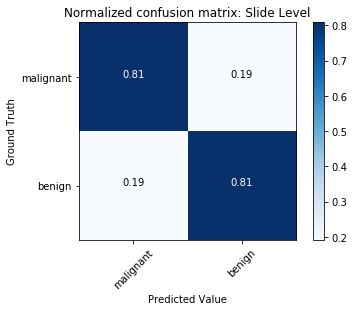

In [20]:
y_test = df['lesion']
y_pred = df['lesion_pred']

cm = confusion_matrix(y_test, y_pred, labels=['malignant', 'benign'])
print(accuracy_score(y_test, y_pred))
plot_confusion_matrix(cm, classes=['malignant', 'benign'], normalize=True, title='Normalized confusion matrix: Slide Level')

### Patient Level Result

In [11]:
df_p = df[['patient', 'benign_pred', 'malignant_pred']]
df_p = df_p.groupby(['patient'], as_index=False).sum()

df_p['lesion_pred'] = np.nan
df_p.loc[ df_p['malignant_pred']>df_p['benign_pred'] ,'lesion_pred'] = 'malignant'
df_p.loc[ df_p['malignant_pred']<df_p['benign_pred'] ,'lesion_pred'] = 'benign'

In [12]:
df_p['lesion'] = np.nan

for index, row in df_p.iterrows():
    patient = row['patient']
    df_p.ix[index,'lesion'] = list(df[df['patient']==patient]['lesion'])[0]

0.882352941176


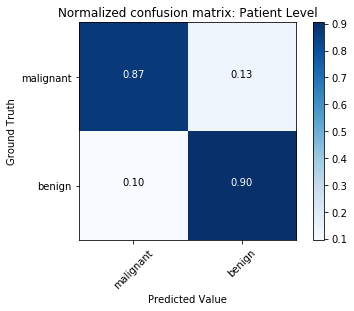

In [21]:
y_test = df_p['lesion']
y_pred = df_p['lesion_pred']

cm = confusion_matrix(y_test, y_pred, labels=['malignant', 'benign'])
print(accuracy_score(y_test, y_pred))
plot_confusion_matrix(cm, classes=['malignant', 'benign'], normalize=True, title='Normalized confusion matrix: Patient Level')